In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [3]:
import pandas as pd
import numpy as np
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()

In [26]:
# shot_types = ['Tip-In', 'Wrist Shot', 'Snap Shot', 'Backhand', 'Slap Shot']
# game_numbers = data_manager.get_game_numbers(2018, "Regular")
# goals_and_shots = pd.DataFrame()
# for game in game_numbers:
#     goals_and_shots = pd.concat([goals_and_shots, data_manager.get_goals_and_shots_df(2018, "Regular", game)[["Type", "Shot Type"]]])
# goals_and_shots.head()

shot_types = ['Tip-In', 'Wrist Shot', 'Snap Shot', 'Backhand', 'Slap Shot']

season_year = 2018
season_type = "Regular"
data_season_df = data_manager.get_season_dataframe(season_year=season_year, season_type=season_type)

goals_and_shots = data_season_df[["Type", "Shot Type"]]
goals_and_shots = goals_and_shots[goals_and_shots["Shot Type"].isin(shot_types)].dropna()

In [29]:
# data_season_df.loc[data_season_df['Empty Net'] == True]

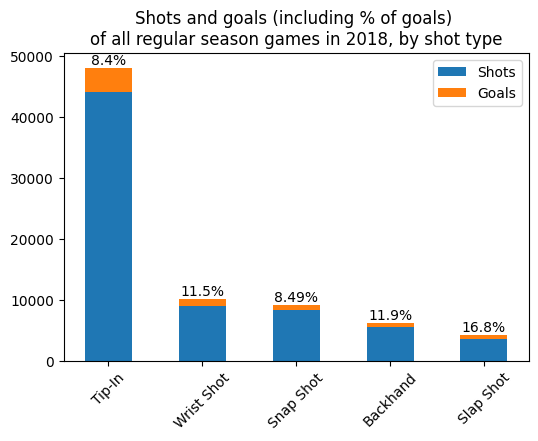

In [28]:
# Q1

import matplotlib.pyplot as plt
from collections import Counter

# filter out NaN values
goals_and_shots = goals_and_shots.dropna()
labels = shot_types

# Grab counts
shots = goals_and_shots[goals_and_shots["Type"] == "SHOT"]
goals = goals_and_shots[goals_and_shots["Type"] == "GOAL"]
shot_counts = Counter(shots["Shot Type"])
goal_counts = Counter(goals["Shot Type"])
shot_counts_filtered = []
goal_counts_filtered = []
for l in labels:
    shot_counts_filtered.append(shot_counts[l])
    goal_counts_filtered.append(goal_counts[l])

shot_counts_filtered = np.sort(np.array(shot_counts_filtered))[::-1]
goal_counts_filtered = np.sort(np.array(goal_counts_filtered))[::-1]
    

fig, ax = plt.subplots(figsize=(6, 4))
p1 = ax.bar(labels, shot_counts_filtered, width=0.5, label='Shots')
p2 = ax.bar(labels, goal_counts_filtered, width=0.5, bottom=shot_counts_filtered, label='Goals')
goal_percent_by_shot_type = [(goal_counts_filtered[i]/(shot_counts_filtered[i]+goal_counts_filtered[i]))*100 for i in range(len(labels))]
plt.bar_label(p2, labels=[f"{p:.3}%" for p in goal_percent_by_shot_type])
plt.xticks(rotation=45)
plt.title(f"Shots and goals (including % of goals) \nof all {season_type.lower()} season games in {season_year}, by shot type")
plt.legend()
plt.savefig('../blogpost/Q4_1.png', bbox_inches="tight")

In [45]:
from tqdm.auto import tqdm

# Q2
shots_by_season = []
skipped = 0
for season in [2018, 2019, 2020]:
    for season_type in ("Regular", "Playoffs"):
        distance_data = pd.DataFrame()
        game_numbers = data_manager.get_game_numbers(season, season_type)
        for game in tqdm(game_numbers):
            try:
                distance_data = pd.concat([distance_data, data_manager.get_goals_and_shots_df_standardised(season, season_type, game)[["Type", "Shot Type", "st_X", "st_Y", "Empty Net"]]])
            except:
                # Sometimes the rinkSide isn't provided...
                # For now we could skip it?
                skipped += 1
                continue
        shots_by_season.append(distance_data)
print(f"Skipped games: {skipped}")

  0%|          | 0/1271 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/1271 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/1271 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

Skipped games: 650


In [67]:
import matplotlib.pyplot as plt
import numpy as np

distances_by_season = []

for season in shots_by_season:
    season['Empty Net'] = season["Empty Net"].fillna(False)
    season = season.dropna()
    distance = np.linalg.norm((season.iloc[:,2:4] - np.array([89,0])).astype(float), axis=1) # Goal is located at (89, 0)
    df = pd.DataFrame()
    df['Type'] = season.Type
    df['distance'] = distance
    distances_by_season.append(df)

In [68]:
for season in distances_by_season:
    print(season.distance.min(), season.distance.max())

1.0 189.6549498431296
3.0 187.6725872363889
1.4142135623730951 188.0239346466295
2.23606797749979 187.52333188166213
1.0 188.0239346466295
1.4142135623730951 185.3887806745597


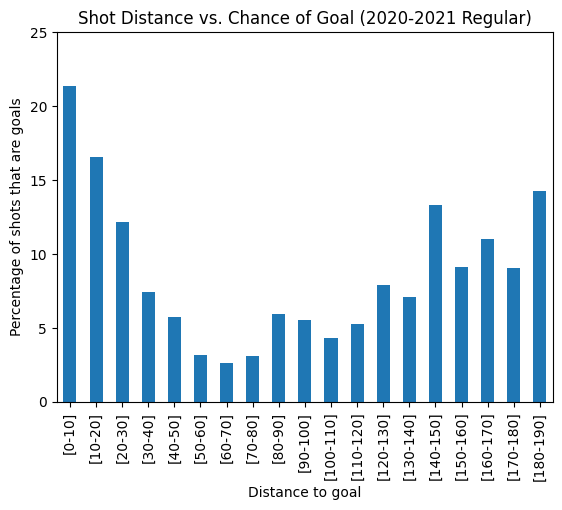

In [72]:
i = 0
for s in [2018, 2019, 2020]:
    # season_types = ("Regular", "Playoffs")
    season_types = ["Regular"]
    for season_type in season_types:
        season = distances_by_season[i]
        shots = season[season.Type == 'SHOT'].distance
        goals = season[season.Type == 'GOAL'].distance
        bins = [i*10 for i in range(20)]
        bin_labels = [f"[{i*10}-{(i+1)*10}]" for i in range(19)]
        shots_bins = pd.cut(shots, bins=bins, labels=bin_labels).value_counts(sort=False)
        goals_bins = pd.cut(goals, bins=bins, labels=bin_labels).value_counts(sort=False)
        goal_percent = (goals_bins / (shots_bins + goals_bins)) * 100
        goal_percent.plot.bar()
        plt.ylim(0, 25)
        plt.xlabel("Distance to goal")
        plt.ylabel("Percentage of shots that are goals")
        plt.title(f"Shot Distance vs. Chance of Goal ({s}-{s+1} {season_type})")
        plt.savefig(f"../blogpost/Q4_2_{s}_{s+1}.png", bbox_inches="tight")
        i += 1

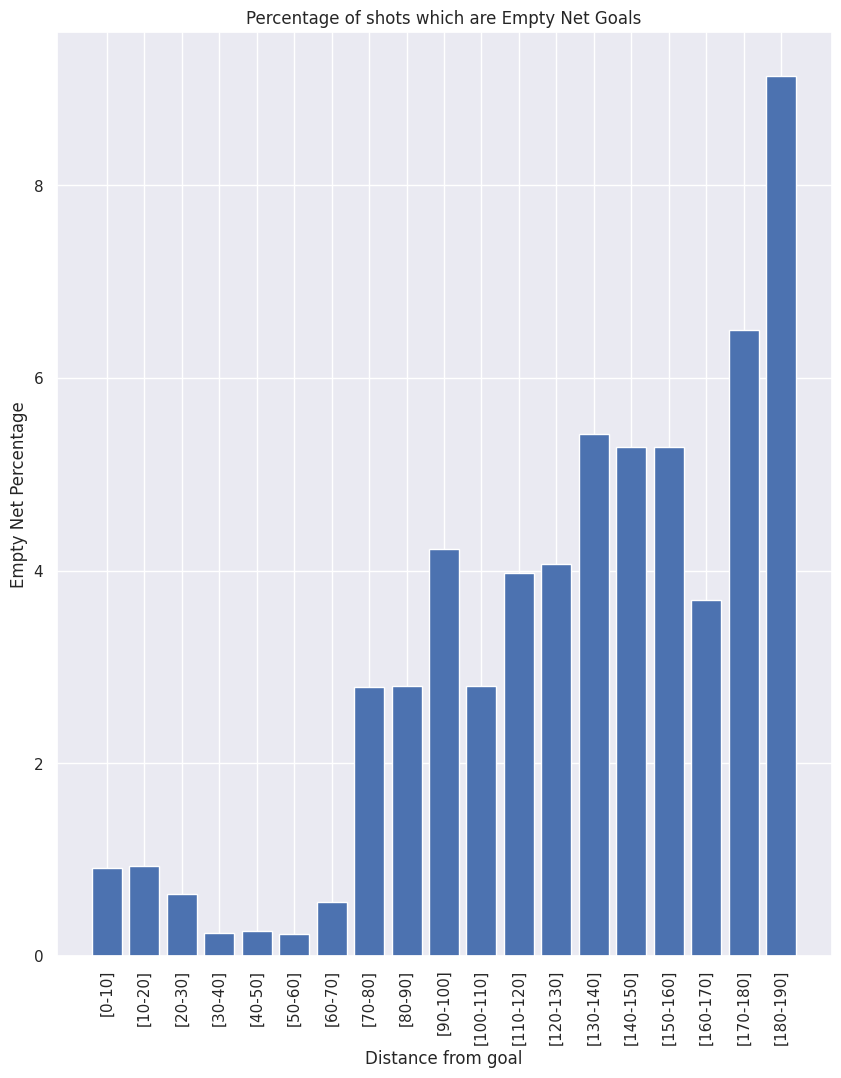

In [120]:
# Empty net percentage graph
distances = distances_by_season[0]
empty_net = shots_by_season[0].dropna()['Empty Net']

binned_distances = pd.DataFrame(pd.cut(distances.distance, bins=bins, labels=bin_labels))
binned_distances["empty_net"] = empty_net
grouped = binned_distances.groupby('distance').value_counts()

ratio = []
for b in bin_labels:
    denom = grouped[b].sum()
    num = grouped[b, True]
    ratio.append((num / denom) * 100)
    
plt.bar(bin_labels, ratio)
plt.xticks(rotation=90)
plt.xlabel("Distance from goal")
plt.ylabel("Empty Net Percentage")
plt.title("Percentage of shots which are Empty Net Goals")
plt.savefig("../blogpost/Q4_2-EmptyNet.png", bbox_inches="tight")

In [115]:
# Q3
bins = [i*10 for i in range(20)]
bin_labels = [f"[{i*10}-{(i+1)*10}]" for i in range(19)]

df = shots_by_season[0].dropna()
df['distance'] = distances_by_season[0].distance
df['distance_bin'] = pd.cut(df.distance, bins=bins, labels=bin_labels)
df = df.drop(labels=['st_X', 'st_Y', 'distance', 'Empty Net'], axis=1)
df

/tmp/ipykernel_774/418468129.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = distances_by_season[0].distance
/tmp/ipykernel_774/418468129.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_bin'] = pd.cut(df.distance, bins=bins, labels=bin_labels)


,Type,Shot Type,distance_bin
0,GOAL,Wrap-around,[0-10]
1,GOAL,Snap Shot,[20-30]
2,GOAL,Snap Shot,[20-30]
3,GOAL,Slap Shot,[30-40]
4,GOAL,Snap Shot,[10-20]
...,...,...,...
55,SHOT,Wrist Shot,[30-40]
56,SHOT,Wrist Shot,[20-30]
57,SHOT,Wrist Shot,[10-20]
58,SHOT,Wrist Shot,[10-20]


In [116]:
import math
heatmap_data = np.zeros((len(bin_labels), len(labels)))
groups = df.groupby(['Shot Type', 'distance_bin']).value_counts()
for i, bin_label in enumerate(bin_labels):
    for j, shot_type in enumerate(labels):
        group = groups[shot_type, bin_label]
        goal_percent = group['GOAL'] / group.sum() * 100
        heatmap_data[i,j] = goal_percent
        # heatmap_data[i,j] = goal_percent if not math.isnan(goal_percent) else 0
heatmap_data = pd.DataFrame(heatmap_data)
heatmap_data.columns = labels
heatmap_data.index = bin_labels

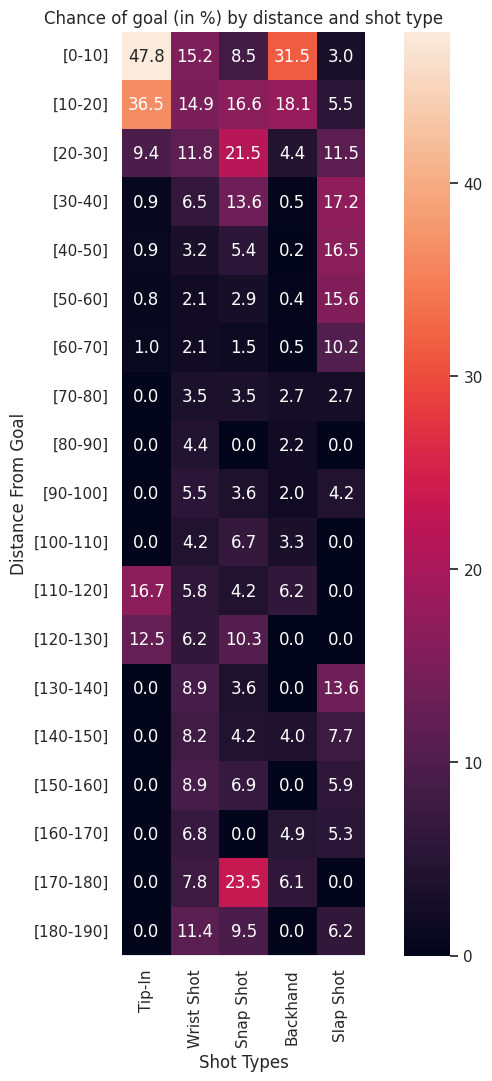

In [127]:
import seaborn as sns
sns.set(rc={"figure.figsize":(10, 12)})
plt.title("Chance of goal (in %) by distance and shot type")
h = sns.heatmap(heatmap_data, square=True, annot=True, fmt=".1f")
h.set(xlabel="Shot Types", ylabel="Distance From Goal")
plt.savefig("../blogpost/Q4_3.png", bbox_inches="tight")